In [47]:
from eventregistry import *
import json, os, sys
import pandas as pd
import numpy as np
from openai import OpenAI
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [39]:
api_key = os.getenv("NEWSAPI_API_KEY")
er = EventRegistry(apiKey=api_key, allowUseOfArchive=False)
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [40]:
def get_article_list(query,lang,max_items):
    article_list = []
    filename = "../data/Q_A/" + query + "_" + lang + ".json"
    if os.path.exists(filename):
        os.remove(filename)
    query = {
    "$query": {
        "$and": [
        {
            "keyword": query,
            "keywordLoc": "body"
        },
        {
            "lang": lang
        }
        ]
    },
    "$filter": {
        "forceMaxDataTimeWindow": "31"
    }
    }
    q = QueryArticlesIter.initWithComplexQuery(query)

    for article in q.execQuery(er, maxItems=max_items):
        article_list.append(article)
    
    with open(filename, "w") as f:
        json.dump(article_list, f, ensure_ascii=False, indent=4)
    
    return article_list


In [64]:
def get_article_list_by_concept_Uri(query,lang,max_items):
    article_list = []
    filename = "../data/Q_A/" + query + "_" + lang + ".json"
    if os.path.exists(filename):
        os.remove(filename)
    query = {
    "$query": {
    "$and": [
      {
        "conceptUri": "http://en.wikipedia.org/wiki/Government_of_India"
      },
      {
        "lang": lang
      }
    ]
  },
  "$filter": {
    "forceMaxDataTimeWindow": "31"
    }
    }
    q = QueryArticlesIter.initWithComplexQuery(query)

    for article in q.execQuery(er, maxItems=max_items):
        article_list.append(article)
    
    with open(filename, "w") as f:
        json.dump(article_list, f, ensure_ascii=False, indent=4)
    
    return article_list

In [41]:
def openai_distinctive_events(
    article,
    openai_client,
    model="gpt-4o",
):

    prompt_complete = (
        f"You are an expert at summarizing the news. \
            Read the the following news article and translate it into English if necessary. \
            Create a list of distinctive events described in the article in English language only, arranged in chronological order. The first event listed should be the earliest event mentioned in the article, followed by the subsequent events in the order they occurred: "
        + article["body"]
    )
    model = model
    messages = [{"role": "user", "content": prompt_complete}]
    try:
        response = openai_client.chat.completions.create(
            model=model, messages=messages, temperature=0
        )

        content = response.choices[0].message.content
        return content
    except Exception as e:  # if the model fails to return a response
        print(f"Error: {e}")
        return "Sorry, error from GPT."

In [42]:
def distinctive_events_query(query,lang):
    src_filename = "../data/Q_A/" + query + "_" + lang + ".json"
    with open(src_filename, "r") as f:
        data = f.read()
        des_articles = []
        src_articles = json.loads(data)
        for src_art in src_articles:
            src_art["distinctive_events"] = openai_distinctive_events(
                src_art, openai_client, model="gpt-4o"
            )

            des_articles.append(src_art)

    des_filename = src_filename + "_distinctive_events.json"
    if os.path.exists(des_filename):
        os.remove(des_filename)
    with open(des_filename, "w") as f:
        json.dump(des_articles, f, indent=4)

In [77]:
def openai_Q_and_A(
    article, questions,
    openai_client,
    model="gpt-4o",
):

    prompt_complete = (
        f"You are an expert at reading the articles and answering set of questions. \
            Read the the following news article and Answer the following questions while selecting the right option in English language only:"+ "Article: " + article["body"]+ "Here are questions and options: " +questions 
            +"Format the response so that each question is followed by its corresponding option on a new line. For example: Does the article favor Congress government?\nC. Not applicable"
    )
    model = model
    messages = [{"role": "user", "content": prompt_complete}]
    try:
        response = openai_client.chat.completions.create(
            model=model, messages=messages, temperature=0
        )

        content = response.choices[0].message.content
        return content
    except Exception as e:  # if the model fails to return a response
        print(f"Error: {e}")
        return "Sorry, error from GPT."

In [44]:
def question_answer_query(query,lang):
    src_filename = "../data/Q_A/" + query + "_" + lang + ".json"
    questions_file = "../data/Q_A/" + query + "_questions.txt"
    with open(questions_file, "r") as f:
        questions = f.readlines()
    questions = "".join(questions)
    with open(src_filename, "r") as f:
        data = f.read()
        des_articles = []
        src_articles = json.loads(data)
        for src_art in src_articles:
            src_art["Q_A"] = openai_Q_and_A(
                src_art, questions, openai_client, model="gpt-4o"
            )

            des_articles.append(src_art)

    des_filename = src_filename + "_Q_A.json"
    if os.path.exists(des_filename):
        os.remove(des_filename)
    with open(des_filename, "w") as f:
        json.dump(des_articles, f, indent=4)

# FUNCTION CALL

In [45]:
#event_1
get_article_list("Ukraine-Russia War", "hin", 10)
distinctive_events_query("Ukraine-Russia War", "hin")
question_answer_query("Ukraine-Russia War", "hin")

In [46]:
# Load the processed JSON file
des_filename = "../data/Q_A/Ukraine-Russia War_hin.json_Q_A.json"
with open(des_filename, "r") as f:
    articles = json.load(f)

# Extract Q&A into a DataFrame
data = []
for article in articles:
    qa_pairs = article["Q_A"].split('\n\n')
    qa_dict = {qa.split('\n')[0]: qa.split('\n')[1] for qa in qa_pairs}
    data.append(qa_dict)

df = pd.DataFrame(data)

  "Does the article portray Russia's actions in Ukraine as justified?  \
0                                                 No                    
1                                                 No                    
2                                                 No                    
3                                                 No                    
4                                                 No                    
5                                                 No                    
6                                                 No                    
7                                                 No                    
8                                                 No                    

  Is the humanitarian impact on Ukrainian civilians highlighted in the article?  \
0                                                 No                              
1                                                 No                              
2                   

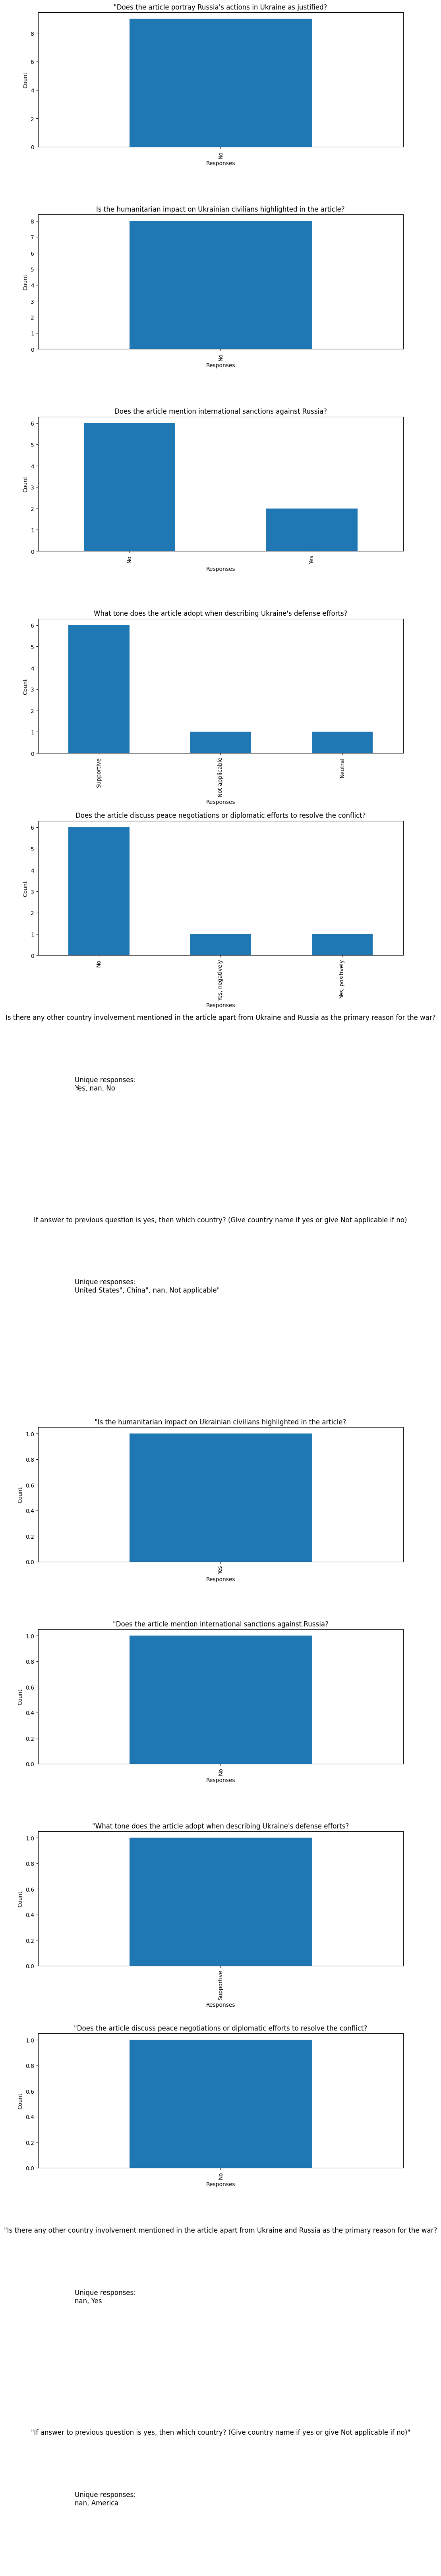

In [49]:
questions = df.columns
fig, axes = plt.subplots(len(questions), 1, figsize=(10, 5 * len(questions)))

for i, question in enumerate(questions):
    if "country" in question.lower():  # Check for string response question based on keyword 'country'
        unique_responses = df[question].unique()
        unique_responses_str = [str(response) for response in unique_responses]  # Convert all responses to string
        axes[i].text(0.1, 0.5, f"Unique responses:\n{', '.join(unique_responses_str)}", fontsize=12)
        axes[i].set_title(question)
        axes[i].axis('off')
    else:
        response_counts = df[question].value_counts()
        response_counts.plot(kind='bar', ax=axes[i])
        axes[i].set_title(question)
        axes[i].set_xlabel('Responses')
        axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

# India General election 2024

In [87]:
#event_2
get_article_list("India election 2024", "eng", 20)
#distinctive_events_query("India election 2024", "hin")
question_answer_query("India election 2024", "eng")

In [78]:
question_answer_query("India election 2024", "hin")

In [88]:
# Load the processed JSON file
des_filename = "../data/Q_A/India election 2024_eng.json_Q_A.json"
with open(des_filename, "r") as f:
    articles = json.load(f)

# Extract Q&A into a DataFrame
data = []
for article in articles:
    qa_pairs = article["Q_A"].split('\n\n')
    qa_dict = {qa.split('\n')[0]: qa.split('\n')[1] for qa in qa_pairs}
    data.append(qa_dict)

df = pd.DataFrame(data)

In [89]:
questions = df.columns

percentage_responses = {}
for question in questions:
    response_counts = df[question].value_counts(normalize=True) * 100  # Calculate percentage
    percentage_responses[question] = response_counts

# Display the percentage responses
for question, percentages in percentage_responses.items():
    print(f"Question: {question}")
    print(percentages.to_string())
    print("\n")

# If you want to save the results to a file
with open("../data/Q_A/response_percentages_eng.txt", "w") as f:
    for question, percentages in percentage_responses.items():
        f.write(f"Question: {question}\n")
        f.write(percentages.to_string())
        f.write("\n\n")

Question: Does the article mention the current government's performance as a major factor in the upcoming elections?
Does the article mention the current government's performance as a major factor in the upcoming elections?
B. No    100.0


Question: Is there a discussion about election-related violence or security concerns in the article?
Is there a discussion about election-related violence or security concerns in the article?
B. No     75.0
A. Yes    25.0


Question: What is the tone of the article towards the main opposition party?
What is the tone of the article towards the main opposition party?
D. Not applicable    75.0
B. Neutral           25.0


Question: Does the article highlight economic issues as a key electoral issue?
Does the article highlight economic issues as a key electoral issue?
B. No    100.0


Question: Is the role of social media in the election campaign mentioned in the article?
Is the role of social media in the election campaign mentioned in the article?
C. N

In [ ]:
get_article_list_by_concept_Uri("Government_of_India", "zho", 100)
distinctive_events_query("Government_of_India", "zho")
question_answer_query("Government_of_India", "zho")

In [82]:
question_answer_query("Government_of_India", "zho")

In [66]:
question_answer_query("Government_of_India", "zho")

In [83]:
# Load the processed JSON file
des_filename = "../data/Q_A/Government_of_India_zho.json_Q_A.json"
with open(des_filename, "r") as f:
    articles = json.load(f)

# Extract Q&A into a DataFrame
data = []
for article in articles:
    qa_pairs = article["Q_A"].split('\n\n')
    qa_dict = {qa.split('\n')[0]: qa.split('\n')[1] for qa in qa_pairs}
    data.append(qa_dict)

df = pd.DataFrame(data)

In [84]:
questions = df.columns

percentage_responses = {}
for question in questions:
    response_counts = df[question].value_counts(normalize=True) * 100  # Calculate percentage
    percentage_responses[question] = response_counts

# Display the percentage responses
for question, percentages in percentage_responses.items():
    print(f"Question: {question}")
    print(percentages.to_string())
    print("\n")

# If you want to save the results to a file
with open("../data/Q_A/response_percentages_zho.txt", "w") as f:
    for question, percentages in percentage_responses.items():
        f.write(f"Question: {question}\n")
        f.write(percentages.to_string())
        f.write("\n\n")

Question: Does the article mention the current government's performance as a major factor in the upcoming elections?
Does the article mention the current government's performance as a major factor in the upcoming elections?
B. No     92.0
A. Yes     8.0


Question: Is there a discussion about election-related violence or security concerns in the article?
Is there a discussion about election-related violence or security concerns in the article?
B. No     98.0
A. Yes     2.0


Question: What is the tone of the article towards the main opposition party?
What is the tone of the article towards the main opposition party?
D. Not applicable    96.0
C. Negative           2.0
A. Positive           1.0
B. Neutral            1.0


Question: Does the article highlight economic issues as a key electoral issue?
Does the article highlight economic issues as a key electoral issue?
B. No     87.0
A. Yes    13.0


Question: Is the role of social media in the election campaign mentioned in the article?
I

In [74]:
er = EventRegistry(apiKey=api_key, allowUseOfArchive=False)
# keywords = "Iran's president"
lang = "hin"
dateStart = "2024-05-01"
dateEnd = "2024-05-30"
eventUri = "hin-362909"
q = QueryEventArticlesIter(
    eventUri=eventUri, lang=lang, dateStart=dateStart, dateEnd=dateEnd
)

filename = dateStart + "_" + lang + ".json"
if os.path.exists(filename):
    os.remove(filename)

articles = []
for art in q.execQuery(
    er,
    sortBy="rel",
    maxItems=10,
    returnInfo=ReturnInfo(
        sourceInfo=SourceInfoFlags(location=True),
    ),
):
    articles.append(art)

with open(filename, "w") as f:
    json.dump(articles, f, ensure_ascii=False, indent=4)